# Vancouver Crime in Relation to Wealth

STAT 201 202 - Emily Wang, Faraz Hosseinian-Tehrani, Giuliana Kim, Yiran Xiong

----

## Project Proposal
### Introduction

In recent years, the picturesque city of Vancouver has been grappling with a mounting concern of crime, with a notable surge in theft cases, which has become an increasingly prevalent issue that poses challenges to the safety and security of its residents. CTV news reported on October 27th of this year that 258 arrests were made in a 2-week period as the Vancouver police department continued the shoplifting crackdown[1]. On October 30th, the B.C. Coalition called for immediate government action on theft, vandalism, and violent crime, and its members say they have reached "epidemic proportions'' across the province[2].

Given the prevalent issue, in our project, we will answer the question: “How do proportions of theft among all crimes differ between neighbourhoods in Vancouver?”. We will be using the crime data set[3] from 2003 to 2023 released by the VPD, to investigate the proportions of robbery, theft of motor vehicles, theft from automotives, and theft under $5,000. The two neighbourhoods we will be comparing are Strathcona (often referred to as Downtown Eastside), the poorest neighbourhood in Vancouver, according to Wikipedia[4] and CBC[5], and Kerrisdale, which is one of the richest neighbourhoods in Vancouver[6][7]. Our location parameter of interest will be the mean value, and our scale parameter of interest will be the standard deviation. We believe that these two parameters will help us answer our question at hand - comparing the proportions of theft in the two neighbourhoods. 

### Hypotheses

Null Hypothesis: The proportion of thefts relative to all crimes is equal between Strathcona and Kerrisdale.
- (H<sub>0</sub>: p<sub>1</sub> = p<sub>2</sub>)

Alternate Hypothesis: The proportion of thefts relative to all crimes is not equal between Strathcona and Kerrisdale.
- (H<sub>a</sub>: p<sub>1</sub> ≠ p<sub>2</sub>)

In [1]:
# Setup
set.seed(3)

library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(ISLR)
library(ggplot2)
library(gridExtra)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading Data

The first step is to read in our data set from the web using the 'read_csv' function. The datasets were originally downloaded from "https://geodash.vpd.ca/opendata", where the data for Kerrisdale and Strathcona were in seperate csvs. So, we read the two csvs seperately and then merged them together into a single data frame using rbind. Our raw dataset also contained a lot of unnecessary columns like the exact time (MONTH, DAY, HOUR, MINUTE) and the precise location (HUNDRED_BLOCK, X, Y) of the crime committed, so we selected only the relevant columns to our study such as "TYPE", "YEAR", and "NEIGHBOURHOOD".


In [2]:
# Load the data from the web
kerrisdale_url <- "https://drive.google.com/uc?export=download&id=1XOj_2FTc-0lW5-8RX9lRBOgzX5A2IMet"
strathcona_url <- "https://drive.google.com/uc?export=download&id=1wXQ8W3kBSo7ija-mhUzCVPbShviQHLNt"
kerrisdale_data <- read_csv(kerrisdale_url) 
strathcona_data <- read_csv(strathcona_url)

# Merge the two data frames into a single data frame:
crime <- rbind(kerrisdale_data, strathcona_data)

# Select only relevant columns to our study
crime <- select(crime, c(TYPE, YEAR, NEIGHBOURHOOD))

# Display data frame
print("Table 1: 2003-2023 Crime Data in Kerrisdale and Stratcona")
head(crime)
tail(crime)

Rows: 11506 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 56640 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: 2003-2023 Crime Data in Kerrisdale and Stratcona"


TYPE,YEAR,NEIGHBOURHOOD
<chr>,<dbl>,<chr>
Break and Enter Commercial,2017,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale
Break and Enter Commercial,2007,Kerrisdale
Break and Enter Commercial,2006,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale


TYPE,YEAR,NEIGHBOURHOOD
<chr>,<dbl>,<chr>
Vehicle Collision or Pedestrian Struck (with Injury),2022,Strathcona
Vehicle Collision or Pedestrian Struck (with Injury),2013,Strathcona
Vehicle Collision or Pedestrian Struck (with Injury),2018,Strathcona
Vehicle Collision or Pedestrian Struck (with Injury),2022,Strathcona
Vehicle Collision or Pedestrian Struck (with Injury),2023,Strathcona
Vehicle Collision or Pedestrian Struck (with Injury),2013,Strathcona


### Cleaning and Wrangling Data
We tidy our data so it follows a consistent format that functions in tidyverse will recognize. We can mutate `NEIGHBOURHOOD` to be a factor to make visualizations and exploratory analysis easier.

In [3]:
# Here we will mutate NEIGHBOURHOOD to a factor so we can visualize it easier 
crime_mutate <- crime |>
mutate(NEIGHBOURHOOD = as_factor(NEIGHBOURHOOD))

# Display tidied data frame
print("Table 2: Tidied Data")
head(crime_mutate)

[1] "Table 2: Tidied Data"


TYPE,YEAR,NEIGHBOURHOOD
<chr>,<dbl>,<fct>
Break and Enter Commercial,2017,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale
Break and Enter Commercial,2007,Kerrisdale
Break and Enter Commercial,2006,Kerrisdale
Break and Enter Commercial,2020,Kerrisdale


### Preliminary exploratory data analysis

To get an idea of the distribution of the crimes committed in both Kerrisdale and Strathcona, we first filter and count by `TYPE` and `YEAR` to get a tally for every crime committed, then we plot the raw data in a stacked bar plot.

In [4]:
# Filter for crimes committed in Kerrisdale
kerrisdale_crimes <- crime_mutate |>
    filter(NEIGHBOURHOOD == "Kerrisdale")

# Filter for crimes committed in Strathcona
strathcona_crimes <- crime_mutate |>
    filter(NEIGHBOURHOOD == "Strathcona")

# Get counts of kerrisdale crimes
kerrisdale_crime_counts <- kerrisdale_crimes |>
    count(TYPE, YEAR)

# Get counts of strathcona crimes
strathcona_crime_counts <- strathcona_crimes |>
    count(TYPE, YEAR)

# Preview data frames
head(kerrisdale_crime_counts)
head(strathcona_crime_counts)

TYPE,YEAR,n
<chr>,<dbl>,<int>
Break and Enter Commercial,2003,41
Break and Enter Commercial,2004,25
Break and Enter Commercial,2005,34
Break and Enter Commercial,2006,31
Break and Enter Commercial,2007,11
Break and Enter Commercial,2008,26


TYPE,YEAR,n
<chr>,<dbl>,<int>
Break and Enter Commercial,2003,190
Break and Enter Commercial,2004,242
Break and Enter Commercial,2005,177
Break and Enter Commercial,2006,137
Break and Enter Commercial,2007,147
Break and Enter Commercial,2008,131


Warning message:
“Removed 41 rows containing missing values (`geom_bar()`).”


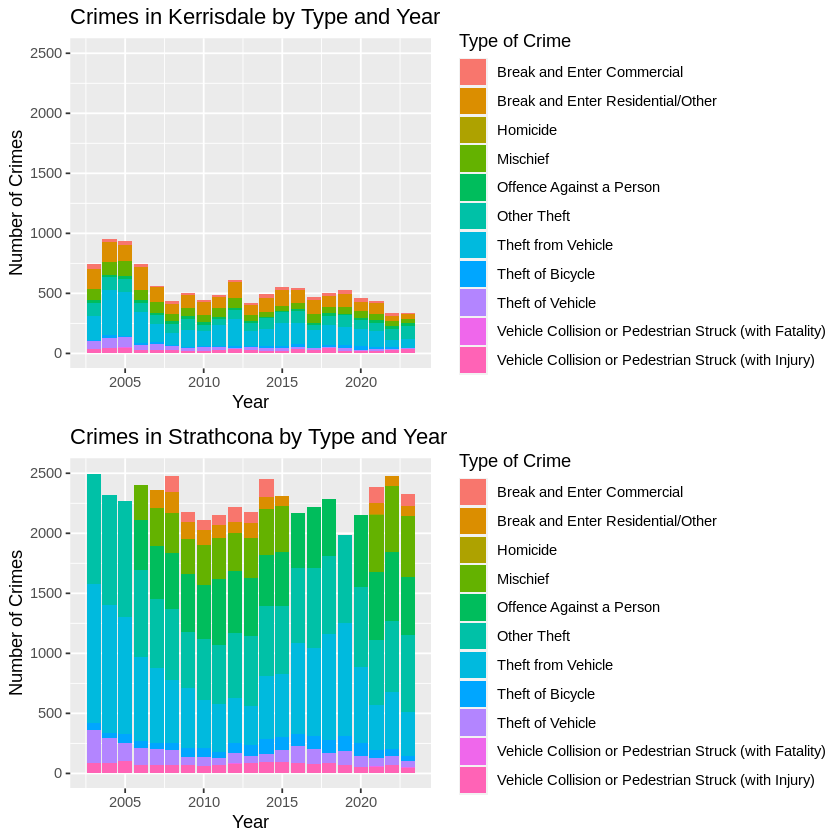

In [5]:
# Create stacked bar plot of raw data
kerrisdale_raw_data_plot <- kerrisdale_crime_counts |>
    ggplot(aes(x = YEAR, y = n, fill = TYPE)) +
    geom_bar(stat = "identity") +
    labs(x = "Year", y = "Number of Crimes", fill = "Type of Crime") +
    ggtitle("Crimes in Kerrisdale by Type and Year") +
    ylim(0, 2500)

# Create stacked bar plot of raw data
strathcona_raw_data_plot <- strathcona_crime_counts |>
    ggplot(aes(x = YEAR, y = n, fill = TYPE)) +
    geom_bar(stat = "identity") +
    labs(x = "Year", y = "Number of Crimes", fill = "Type of Crime") +
    ggtitle("Crimes in Strathcona by Type and Year") +
    ylim(0, 2500)

# Display plots
grid.arrange(kerrisdale_raw_data_plot, strathcona_raw_data_plot)

Now, to calculate proportions, we group the data into thefts and non-thefts.

In [6]:
kerrisdale_crimes_grouped <- kerrisdale_crimes |>
    mutate(TYPE = ifelse(TYPE %in% c("Theft of Bicycle", "Theft of Vehicle", "Theft from Vehicle", "Other Theft"), 
                         "Theft", "Other")) 

strathcona_crimes_grouped <- strathcona_crimes |>
    mutate(TYPE = ifelse(TYPE %in% c("Theft of Bicycle", "Theft of Vehicle", "Theft from Vehicle", "Other Theft"), 
                         "Theft", "Other"))

kerrisdale_counts <- kerrisdale_crimes_grouped |>
    count(TYPE)

strathcona_counts <- strathcona_crimes_grouped |>
    count(TYPE)

To get a visual understanding of the proportions for each neighbourhood, we will make a pie chart of the total theft vs non-theft crimes.

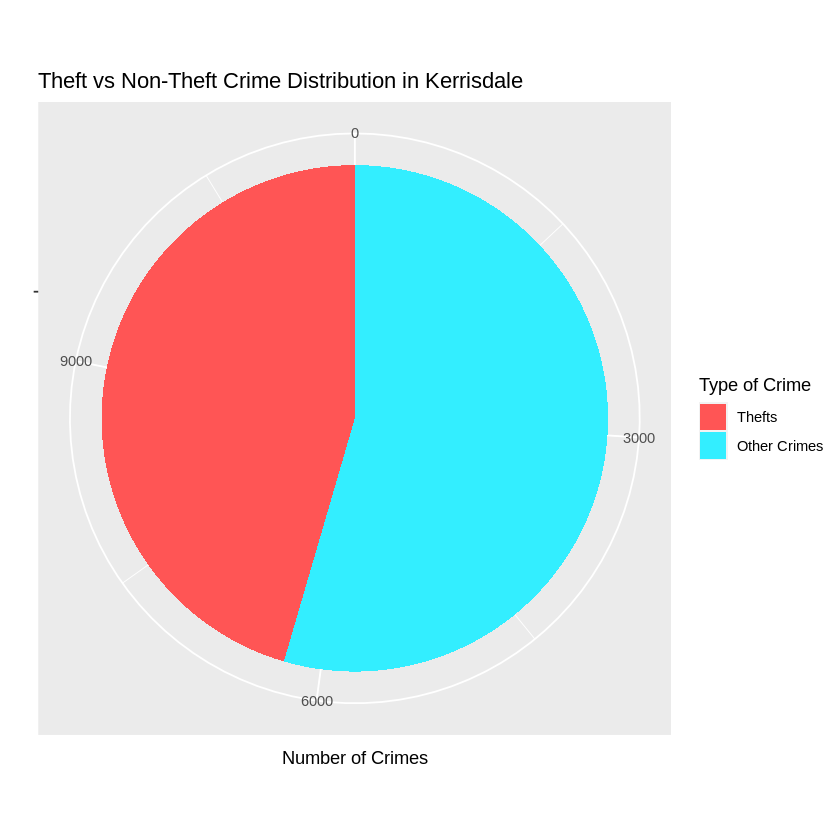

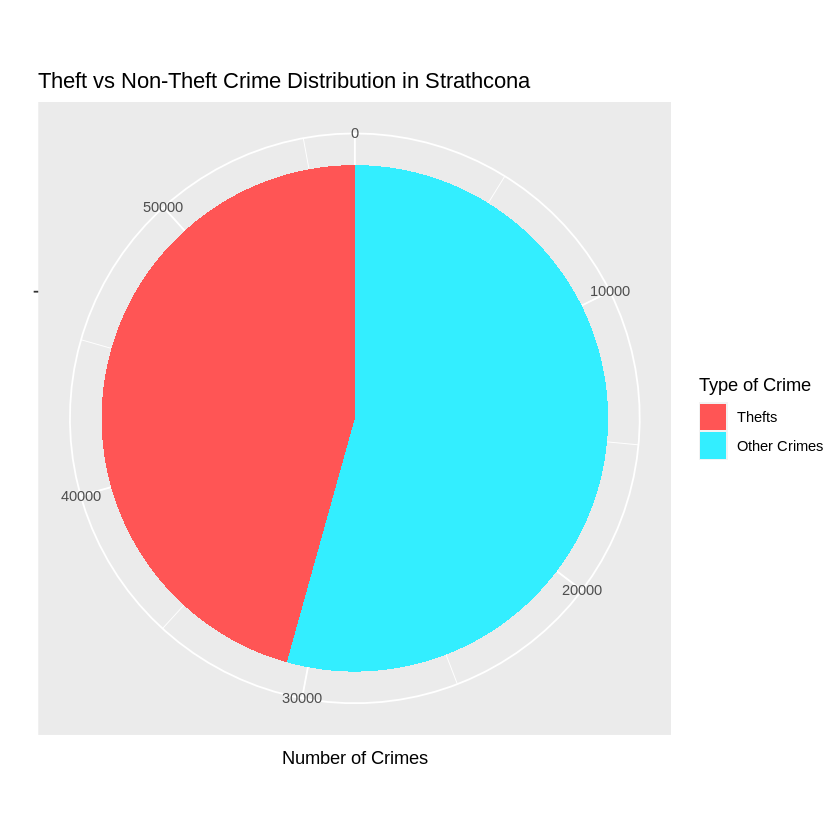

In [7]:
kerrisdale_pie_chart <- ggplot(kerrisdale_counts, aes(x = "", y = c(n[1], n[2]), fill = factor(n))) +
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y") +
    labs(x = "", y = "Number of Crimes", fill = "Type of Crime") +
    ggtitle("Theft vs Non-Theft Crime Distribution in Kerrisdale") +
    scale_fill_manual(values = c("#ff5555", "#33eeff"), labels = c("Thefts", "Other Crimes"))

strathcona_pie_chart <- ggplot(strathcona_counts, aes(x = "", y = c(n[1], n[2]), fill = factor(n))) +
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y") +
    labs(x = "", y = "Number of Crimes", fill = "Type of Crime") +
    ggtitle("Theft vs Non-Theft Crime Distribution in Strathcona") +
    scale_fill_manual(values = c("#ff5555", "#33eeff"), labels = c("Thefts", "Other Crimes"))

kerrisdale_pie_chart
strathcona_pie_chart

Next, we get a proportion value for each year.

In [12]:
kerrisdale_yearly_proportions <- kerrisdale_crimes_grouped |>
    group_by(YEAR, TYPE) |>
    summarise(count = n()) |>
    spread(TYPE, count, fill = 0) |>
    mutate(Proportion = Theft / (Theft + Other))

strathcona_yearly_proportions <- strathcona_crimes_grouped |>
    group_by(YEAR, TYPE) |>
    summarise(count = n()) |>
    spread(TYPE, count, fill = 0) |>
    mutate(Proportion = Theft / (Theft + Other))

kerrisdale_yearly_proportions
strathcona_yearly_proportions

`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


YEAR,Other,Theft,Proportion
<dbl>,<dbl>,<dbl>,<dbl>
2003,362,385,0.5153949
2004,363,592,0.6198953
2005,370,569,0.6059638
⋮,⋮,⋮,⋮
2021,201,233,0.5368664
2022,160,179,0.5280236
2023,142,195,0.5786350


YEAR,Other,Theft,Proportion
<dbl>,<dbl>,<dbl>,<dbl>
2003,1112,2407,0.6840011
2004,1210,2229,0.6481535
2005,1148,2172,0.6542169
⋮,⋮,⋮,⋮
2021,1332,1052,0.4412752
2022,1410,1199,0.4595631
2023,1220,1105,0.4752688


### Parameter Estimates

First, we'll find the deviation of proportions between years.

In [13]:
kerrisdale_sd <- sd(kerrisdale_yearly_proportions$Proportion)
strathcona_sd <- sd(strathcona_yearly_proportions$Proportion)

kerrisdale_sd
strathcona_sd

[1] 0.04018941

[1] 0.06592044

Next, we'll find the total proportions for Kerrisdale and Strathcona across all the years.

In [14]:
# Kerrisdale Sample Size
n1 <- kerrisdale_counts$n[1] + kerrisdale_counts$n[2]

# Kerrisdale Proportion
p1 <- kerrisdale_counts$n[2] / n1

# Strathcona Sample Size
n2 <- strathcona_counts$n[1] + strathcona_counts$n[2]

# Strathcona Proportion
p2 <- strathcona_counts$n[2] / n2

print(paste("Kerrisdale Sample Size:", n1, ", Kerrisdale Proportion:", p1))
print(paste("Strathcona Sample Size:", n2, ", Strathcona Proportion:", p2))

[1] "Kerrisdale Sample Size: 11506 , Kerrisdale Proportion: 0.545193811924213"
[1] "Strathcona Sample Size: 56640 , Strathcona Proportion: 0.543290960451977"


In [15]:
diff_in_props <- abs(p1 - p2)

print(paste("Difference in Proportions: ", diff_in_props))

[1] "Difference in Proportions:  0.00190285147223601"


### Methods

Our report conducts a data analysis of crime data from two Vancouver communities, Kerrisdale and Strathcona, with a focus on the proportion of theft-related crimes in these areas. From our process, we first perform a hypothesis test to determine whether the proportions of theft to other crimes are statistically different between Kerrisdale and Strathcona. The data is then grouped, summarized, and visualized to understand the distribution of different crime types over the years. 

Several factors strengthen our report and make it reputable. Firstly, our real crime comes directly from the Vancouver Police Department. Using official data lends credibility to the analysis. Secondly, our report analyses the data by summarizing data and creating informative plots to visualize the distribution of crime types over the years in Kerrisdale and Strathcona. The tidy data format and analysis make the data easier to understand and work with. 

However, there are also insufficiencies in our report. Our report so far only contains and provides the virtualization of the different crime proportions of Kerrisdale and Strathcona. We have not quantified the uncertainty associated with the estimates yet. 

### Expected outcomes and significance:
- What do you expect to find?

Based on our hypotheses, we would expect to find one of the following outcomes:

If our analysis shows that the proportion of thefts to other crimes is statistically equal between Strathcona and Kerrisdale, we would fail to reject the null hypothesis. This would indicate that the economic status of a community does not have a significant impact on the proportion of theft-related crimes.

If our analysis reveals a significant difference in the proportion of thefts to other crimes between the two communities, we should reject the null hypothesis. This would suggest that the economic status of a community does have a significant impact on the proportion of theft-related crimes.

- What impact could such findings have?

The findings of our report could reveal how socioeconomic disparities relate to crime rates. The conclusion and supporting information would help local governments and law enforcement agencies allocate resources and implement policies more effectively.

- What future questions could this lead to?

Although our research and report would establish a statistical association of the proportion of thefts to other crimes in the two communities, it does not include the analysis and explanation of the underlying causes. Future research can analyze the causal factors contributing to the differences in crime rates between Strathcona and Kerrisdale. Also, our report only focuses on the two communities in Vancouver. The observed pattern we get from our research may be unique in Kerrisdale and Strathcona. Future research could expand the testing area into other communities and cities. 

#### References

[1]: Clarkson, B. (2023, October 27). *258 arrests made in 2-week period as Vancouver police continue shoplifting crackdown.* CTV News. https://bc.ctvnews.ca/258-arrests-made-in-2-week-period-as-vancouver-police-continue-shoplifting-crackdown-1.6620249

[2]: CBC/Radio Canada. (2023, October 31). *B.C. Coalition seeks “critical” crackdown on violent retail crime.* CBC News. https://www.cbc.ca/news/canada/british-columbia/save-our-streets-seeks-crackdown-on-violent-retail-crimes-1.7013229 

[3]: GeoDASH. (2003 - 2023) *Crime Data Download.* Vancouver Police Department. https://geodash.vpd.ca/opendata/#

[4]: Wikimedia Foundation. (2023, September 29). *Downtown Eastside.* Wikipedia. https://en.wikipedia.org/wiki/Downtown_Eastside#:~:text=The%20Downtown%20Eastside%20(DTES)%20is,mental%20illness%20and%20sex%20work 

[5]: CBC/Radio Canada. (2013, July 18). *Weighing in on future of Vancouver’s Downtown Eastside.* CBC News. https://www.cbc.ca/news/canada/british-columbia/weighing-in-on-future-of-vancouver-s-downtown-eastside-1.1356400 

[6]: Borenstein, A. ‘Bo.’ (2023, February 3). *Where do the rich in vancouver live?* the Best Vancouver. https://www.thebestvancouver.com/where-do-rich-in-vancouver-live/ 

[7]: Cantech Letter. (2023, July 3). *The five wealthiest neighbourhoods in Vancouver, listed.* Cantech Letter. https://www.cantechletter.com/2023/07/the-five-wealthiest-neighbourhoods-in-vancouver-listed/ 